In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset (replace with your dataset path)
df = pd.read_csv('laptop_prices.csv')





In [40]:
#Initialize EDA
df.describe()

,RAM (GB),Screen Size (inch),Battery Life (hours),Weight (kg),Price ($)
count,11768.000000,11768.000000,11768.000000,11768.000000,11768.000000
mean,24.852821,15.212305,8.027855,2.341117,2183.571608
std,21.762567,1.436997,2.305400,0.667921,1316.886132
min,4.000000,13.300000,4.000000,1.200000,279.570000
25%,8.000000,14.000000,6.000000,1.760000,1272.045000
50%,16.000000,15.600000,8.000000,2.340000,1840.865000
75%,32.000000,16.000000,10.000000,2.910000,2698.370000
max,64.000000,17.300000,12.000000,3.500000,10807.880000


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11768 entries, 0 to 11767
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Brand                 11768 non-null  object 
 1   Processor             11768 non-null  object 
 2   RAM (GB)              11768 non-null  int64  
 3   Storage               11768 non-null  object 
 4   GPU                   11768 non-null  object 
 5   Screen Size (inch)    11768 non-null  float64
 6   Resolution            11768 non-null  object 
 7   Battery Life (hours)  11768 non-null  float64
 8   Weight (kg)           11768 non-null  float64
 9   Operating System      11768 non-null  object 
 10  Price ($)             11768 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 1011.4+ KB


In [44]:
# 1. Data Cleaning and Preprocessing

# Handle missing values (drop rows with missing data)
df.dropna(inplace=True)

# Convert storage to numeric (if TB exists, convert to GB)
def convert_storage(storage):
    total_storage = 0
    for s in storage.split():
        if 'TB' in s:
            total_storage += float(s.replace('TB', '')) * 1024
        elif 'GB' in s:
            total_storage += float(s.replace('GB', ''))
    return total_storage

df['Storage (GB)'] = df['Storage'].apply(convert_storage)

# Split screen resolution into width and height
df[['Resolution Width', 'Resolution Height']] = df['Resolution'].str.extract(r'(\d+)x(\d+)').astype(float)

# Calculate Pixel Density (PPI)
df['PPI'] = np.sqrt(df['Resolution Width']**2 + df['Resolution Height']**2) / df['Screen Size (inch)']



In [36]:
# Ensure only numeric columns are used
numeric_df = df.select_dtypes(include=['number'])
 # 2. Handle Outliers (IQR Method)
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1
df = numeric_df[~((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).any(axis=1)]

Mean Squared Error (MSE): 0.12137907836241425
R-squared (R²): 0.6030725245137867
Model Accuracy (R² in original scale): 57.291886203612975 %


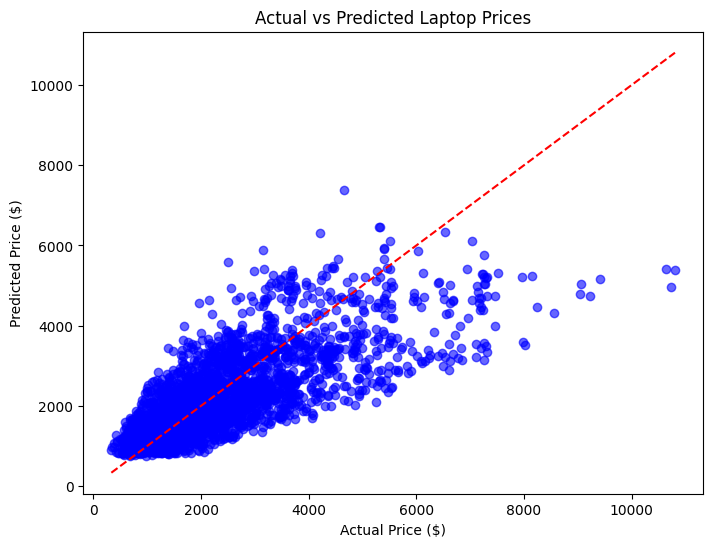

In [47]:
# 2. Feature Engineering
# Create interaction features
df['RAM_Screen_Weight_Interaction'] = df['RAM (GB)'] * df['Screen Size (inch)'] * df['Weight (kg)']
df['Storage_Battery_Interaction'] = df['Storage (GB)'] * df['Battery Life (hours)']
df['Resolution_Weight_Interaction'] = df['Resolution Width'] * df['Weight (kg)']

# Apply log transformation to skewed variables (Price)
df['log_Price'] = np.log1p(df['Price ($)'])

# 3. Feature Selection
features_selected = ['RAM (GB)', 'Screen Size (inch)', 'Battery Life (hours)', 'Weight (kg)',
                     'Storage (GB)', 'Resolution Width', 'Resolution Height', 'PPI',
                     'RAM_Screen_Weight_Interaction', 'Storage_Battery_Interaction', 'Resolution_Weight_Interaction']

X = df[features_selected]
y = df['log_Price']

# 4. Adding Polynomial Features (degree 3 for more complex relationships)
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)

# 5. Data Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

# 6. Split Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# 7. Model Training (Linear Regression)
model = LinearRegression()
model.fit(X_train, y_train)

# 8. Model Evaluation
y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Convert log predictions back to original price
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test)

# Final Accuracy
final_r2 = r2_score(y_test_original, y_pred_original)

# Display results
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)
print("Model Accuracy (R² in original scale):", final_r2 * 100, "%")

# Optional: Visualization
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_original, color='blue', alpha=0.6)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], '--r')
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Actual vs Predicted Laptop Prices")
plt.show()

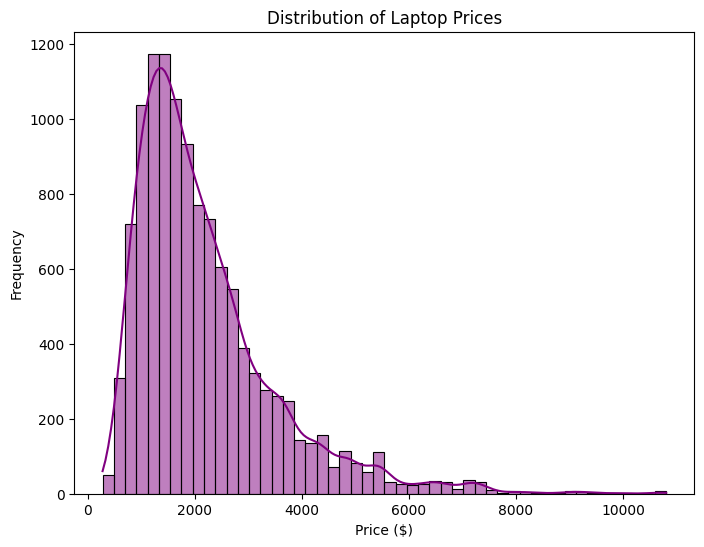

In [48]:
# Additional Visualization: Distribution of Target Variable
plt.figure(figsize=(8, 6))
sns.histplot(df['Price ($)'], bins=50,kde=True, color='purple')
plt.title("Distribution of Laptop Prices")
plt.xlabel("Price ($)")
plt.ylabel("Frequency")
plt.show()